# Ensemble of heteroskedastic deep neural networks

In [8]:
import jax
import distrax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable
from flax.core import freeze
from functools import partial
from dynamax.utils import datasets
from flax.training.train_state import TrainState

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [485]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

## The model

In [576]:
class HetMLP(nn.Module):
    dim_out: int
    activation: Callable = nn.relu
        
    @nn.compact
    def __call__(self, x):
        # Shared components
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)

        mean = nn.Dense(self.dim_out, name="mean")(x)
        logvar = nn.Dense(self.dim_out, name="ustd")(x)
        
        return mean, logvar
    
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn(params, X, y, applyfn):
    mean, logvar = applyfn(params, X)
    # scale = jax.nn.softplus(logvar).ravel()
    scale = jnp.exp(logvar / 2).ravel()
    mean = mean.ravel()
    
    likelihood = distrax.Normal(loc=mean, scale=scale).log_prob(y)
    return -likelihood.mean()

In [577]:
def generate_rotated_images(images, angles, n_processes=1):
    n_configs = len(images)
    processer = datasets.DataAugmentationFactory(datasets.rotate_mnist)
    configs = [{"angle": float(angle)} for angle in angles]
    images_proc = processer(images, configs, n_processes=n_processes)
    return images_proc, angles

## Rotating MNIST

## Setup

In [903]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=1, maxangle=180)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)


# X_train = X_train.reshape(-1, 28, 28)
# X_test = X_test.reshape(-1, 28, 28)
num_train, *dim_input = X_train.shape

# Introducing trenches
map_trench_1 = (y_train  >= 0) & (y_train <= 45)
map_trench_2 = (y_train >= 90) & (y_train <= 135)
map_trench = map_trench_1 | map_trench_2

y_train = y_train[map_trench]
X_train = X_train[map_trench]

In [901]:
batch_size = 100
batch = (batch_size, *dim_input)
model = HetMLP(1, activation=nn.elu)
batch = jnp.ones(batch)

In [902]:
params_init = model.init(key_init, batch)
params_init = params_init.unfreeze()
s_init = params_init["params"]["ustd"]["kernel"]  
params_init["params"]["ustd"]["kernel"] = jnp.zeros_like(s_init) - 0.5
params_init = freeze(params_init)

### Training

In [581]:
import optax
from rebayes import batch_sgd as bsgd

In [582]:
from tqdm.notebook import tqdm

In [583]:
num_epochs = 5_000
batch_size = 500
keys_train = jax.random.split(key_train, num_epochs)
loss_grad = jax.value_and_grad(lossfn, 0)

state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-4)
)

losses = []
crossval = []

elements  = list(enumerate(keys_train))
pbar = tqdm(elements)
for (e, key) in pbar:
    loss, state, = bsgd.train_epoch(key, batch_size, state, X_train, y_train, loss_grad)
    losses.append(loss.item())
    
    xv_test = lossfn(state.params, X_test, y_test, state.apply_fn)
    crossval.append(xv_test.item())

    losstr = f"{loss:0.4e}"
    pbar.set_description(losstr)

  0%|          | 0/5000 [00:00<?, ?it/s]

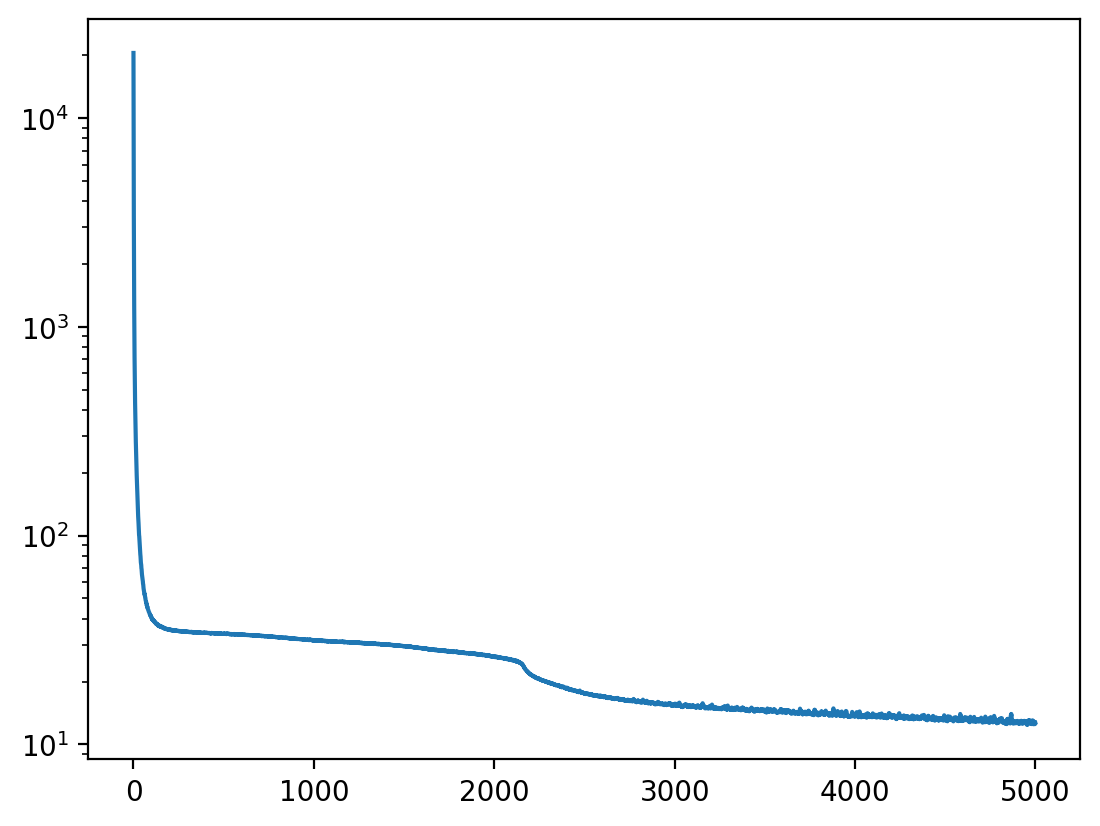

In [584]:
plt.plot(losses)
plt.yscale("log")

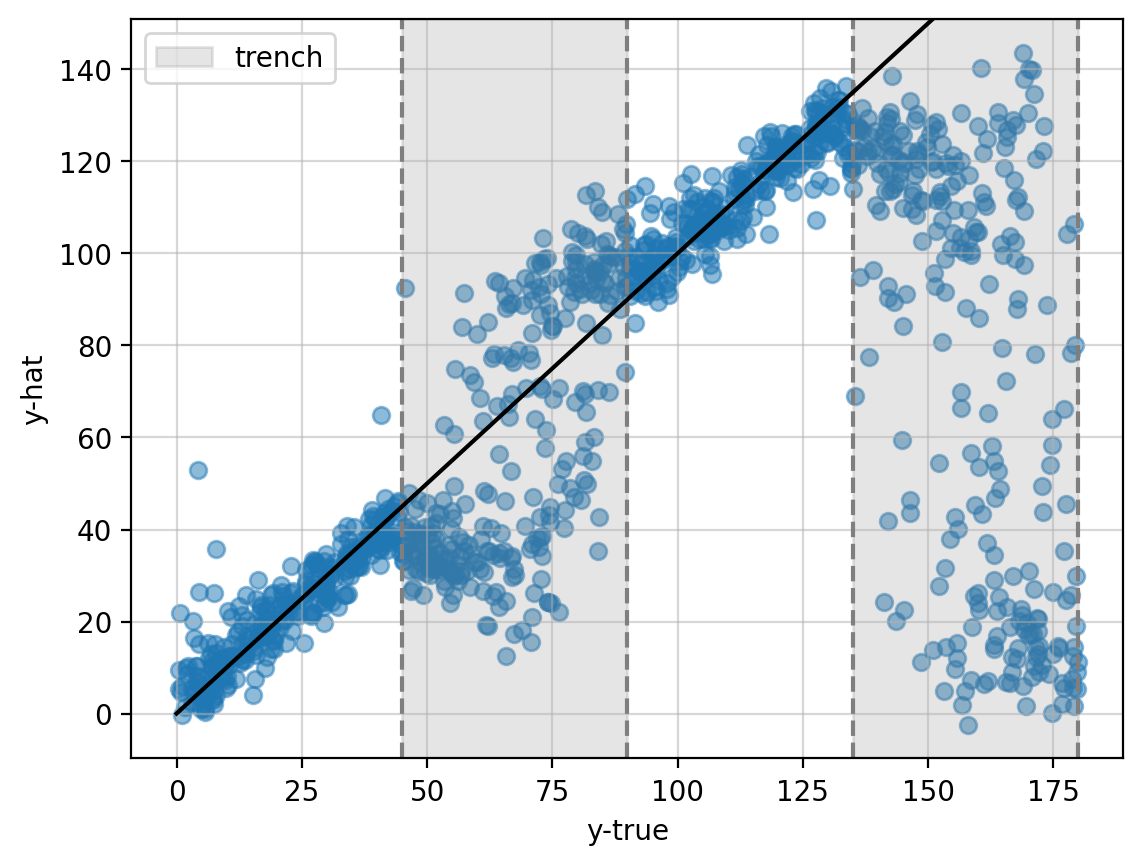

In [585]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)
vmin, vmax = y_test.min(), y_test.max()

res_test = state.apply_fn(state.params, X_test)
yhat_test, std_test = res_test
std_test = jnp.exp(std_test / 2).ravel()
# std_test = jax.nn.softplus(std_test).ravel()
yhat_test = yhat_test.ravel()

plt.scatter(y_test, yhat_test, alpha=0.5, edgecolors=None)

plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

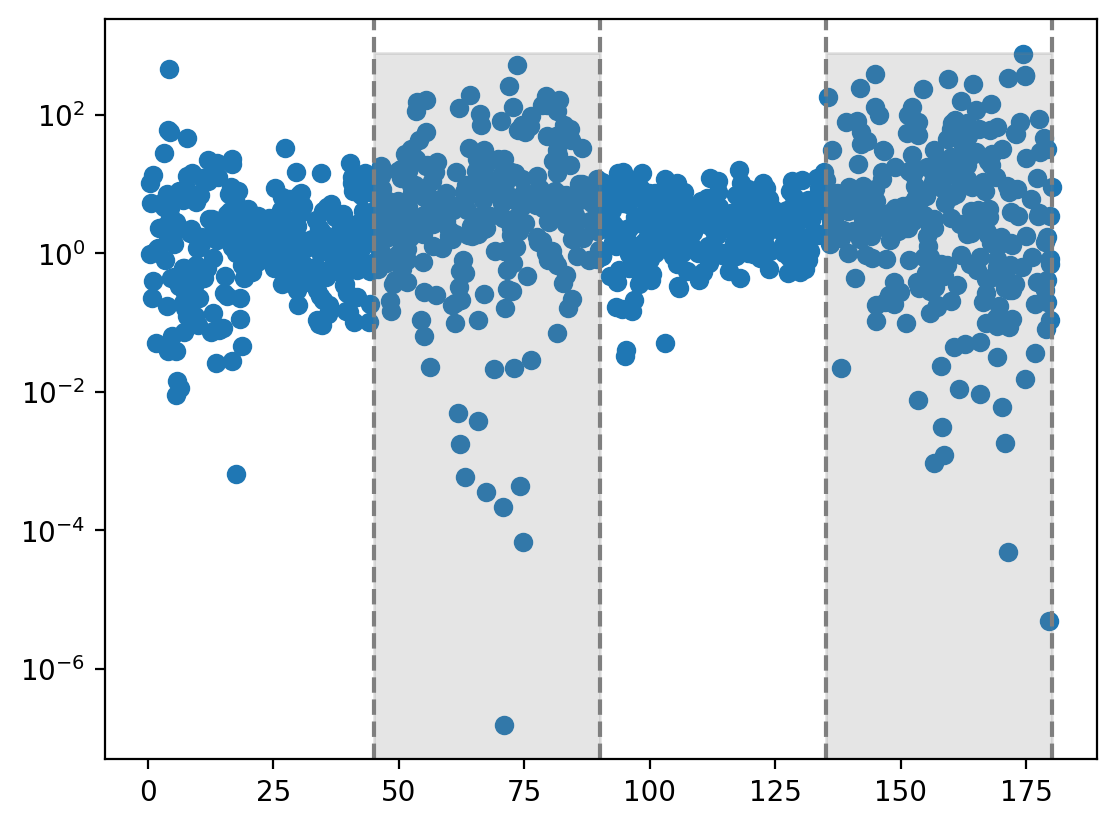

In [586]:
ix_sort = jnp.argsort(y_test)
plt.scatter(y_test[ix_sort], std_test[ix_sort])
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")
plt.yscale("log")

In [587]:
ix_target = 0
x_target = np.array(X_test[ix_target]).reshape(28, 28)
y_init = float(y_test[ix_target].item())
x_target = datasets.rotate_mnist(x_target, -y_init).ravel()

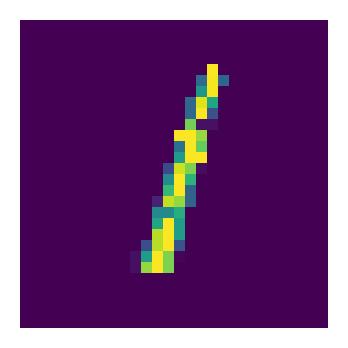

In [588]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(x_target.reshape(28, 28))
ax.axis("off");

In [589]:
n_rotations = 1000
rotations = np.linspace(0, 360, n_rotations)
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 360, 100)

In [590]:
X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)

In [591]:
%%time
res_test = state.apply_fn(state.params, X_target)
yhat_mean, yhat_std = res_test
yhat_std = jnp.exp(yhat_std / 2).ravel()
yhat_mean = yhat_mean.ravel()

CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 91.8 ms


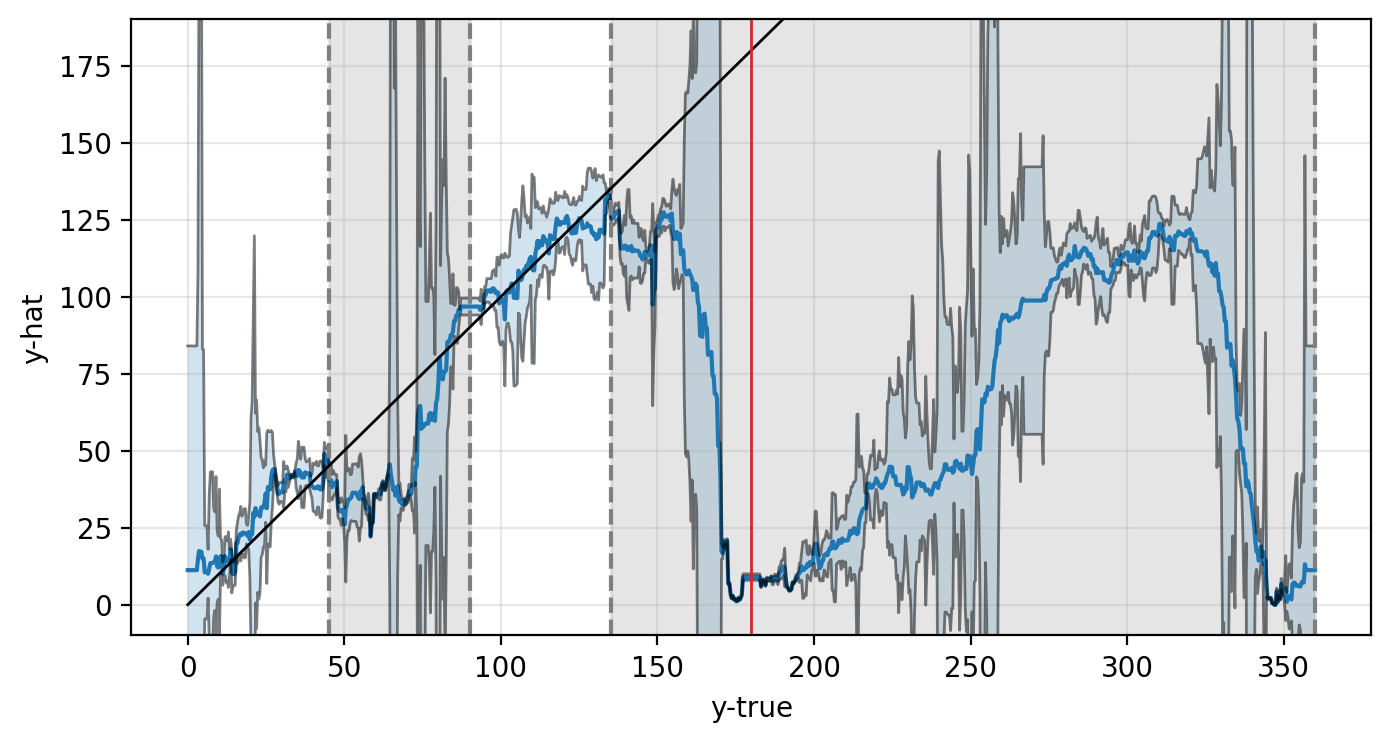

In [592]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(y_target, yhat_mean)

lbound = yhat_mean - 1.96 * yhat_std
ubound = yhat_mean + 1.96 * yhat_std
plt.fill_between(y_target, lbound, ubound, alpha=0.2)
plt.plot(y_target, lbound, c="black", linewidth=1, alpha=0.5)
plt.plot(y_target, ubound, c="black", linewidth=1, alpha=0.5)

plt.xlabel("y-true")
plt.ylabel("y-hat")

ymin, ymax  = plt.ylim()


plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=360, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

plt.plot([0, 360], [0, 360], c="black", linewidth=1)
plt.ylim(ymin, ymax)
plt.ylim(-10, 190)

plt.axvline(x=180, c="tab:red", linewidth=1)

plt.grid(alpha=0.3)

## Ensemble

In [593]:
from jax.flatten_util import ravel_pytree

In [904]:
def create_train_state(params):
    state = TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optax.adam(1e-4)
    )
    return state


def step_train(state, key):
    loss, state, = bsgd.train_epoch(key, batch_size, state, X_train, y_train, loss_grad)
    # xv_test = lossfn(state.params, X_test, y_test, state.apply_fn)    
    return state, loss


def init_and_train(key):
    num_epochs = 5_000
    key_init, key_train = jax.random.split(key)
    keys_train = jax.random.split(key_train, num_epochs)

    key_params, key_std = jax.random.split(key_init)
    params = model.init(key_params, batch)
    
    params = params.unfreeze()
    s_init = params["params"]["ustd"]["kernel"]  
    num_params = len(s_init)
    diff = jax.random.uniform(key_std, minval=0.0, maxval=2.0, shape=(num_params,1))
    params["params"]["ustd"]["kernel"] = jnp.zeros_like(s_init) + diff
    params = freeze(params)    
    
    state = create_train_state(params)
    state, crossval = jax.lax.scan(step_train, state, keys_train)
    return state, crossval

## Train ensemble

In [ ]:
%%time
size_ensemble = 30
key_vtrain = jax.random.split(key, size_ensemble)
state, crossval = jax.vmap(init_and_train)(key_vtrain)
crossval = jax.block_until_ready(crossval)

In [ ]:
plt.plot(crossval.T, c="tab:gray", alpha=0.1)
plt.yscale("log")
plt.grid(alpha=0.09)

## Mean and variance of the Heteroskedastic Ensemble

$$
    \mathbb{E}[y\vert x] \approx \frac{1}{B}\sum_{b=1}^B \mu_{f_b}(x)
$$

and
$$
    \text{Var}[y\vert x] \approx \frac{1}{B}\sum_{b=1}^B\left(\mu_{f_b}(x)^2 + \sigma^2_{f_b}(x)\right)
    -\left(\frac{1}{B}\sum_{b=1}^B\mu_{f_b}(x)\right)^2
$$

In [ ]:
%%time
res_elements = jax.vmap(state.apply_fn, (0, None))(state.params, X_test)
yhat_samples, logvar_samples = res_elements
yhat_samples = yhat_samples.squeeze()

var_samples = jnp.exp(logvar_samples).squeeze()

yhat_std = (yhat_samples ** 2 + var_samples).mean(axis=0) - yhat_samples.mean(axis=0) ** 2
yhat_std = jnp.sqrt(yhat_std)

In [ ]:
yhat_test = yhat_samples.mean(axis=0)

In [ ]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)

plt.scatter(y_test, yhat_test, alpha=0.5, edgecolors=None)

plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

In [ ]:
ix_sort = jnp.argsort(y_test)
plt.scatter(y_test[ix_sort], yhat_std[ix_sort], s=10)
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")
plt.yscale("log")

### Evaluating the posterior predictive as a function of rotation angle

In [ ]:
ix_target = 1
x_target = np.array(X_test[ix_target]).reshape(28, 28)
y_init = float(y_test[ix_target].item())
x_target = datasets.rotate_mnist(x_target, -y_init).ravel()

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(x_target.reshape(28, 28))
ax.axis("off");

In [ ]:
n_rotations = 360
maxangle = 360
rotations = np.linspace(0, maxangle, n_rotations)
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, maxangle, 100)

In [ ]:
X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)

In [ ]:
%%time
res_elements = jax.vmap(state.apply_fn, (0, None))(state.params, X_target)
yhat_samples, logvar_samples = res_elements
yhat_samples = yhat_samples.squeeze()
var_samples = jnp.exp(logvar_samples).squeeze()
std_samples = jnp.exp(logvar_samples / 2).squeeze()

In [ ]:
yhat_mean = yhat_samples.mean(axis=0)
# yhat_std = yhat_samples.std(axis=0)
# yhat_std = std_samples.mean(axis=0)
yhat_std = (yhat_samples ** 2 + var_samples).mean(axis=0) - yhat_samples.mean(axis=0) ** 2
yhat_std = jnp.sqrt(yhat_std)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(y_target, yhat_mean)

lbound = yhat_mean - 1.96 * yhat_std
ubound = yhat_mean + 1.96 * yhat_std
plt.fill_between(y_target, lbound, ubound, alpha=0.2)
plt.plot(y_target, lbound, c="black", linewidth=1, alpha=0.5)
plt.plot(y_target, ubound, c="black", linewidth=1, alpha=0.5)

plt.xlabel("y-true")
plt.ylabel("y-hat")

ymin, ymax  = plt.ylim()


plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=maxangle, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

plt.plot([0, maxangle], [0, maxangle], c="black", linewidth=1)
plt.ylim(ymin, ymax)
plt.ylim(-25, 160)
plt.axvline(x=180, c="tab:red", linewidth=1)

plt.grid(alpha=0.3)


## Animation

In [742]:
from matplotlib.animation import FuncAnimation

CPU times: user 13min 10s, sys: 0 ns, total: 13min 10s
Wall time: 13min 6s


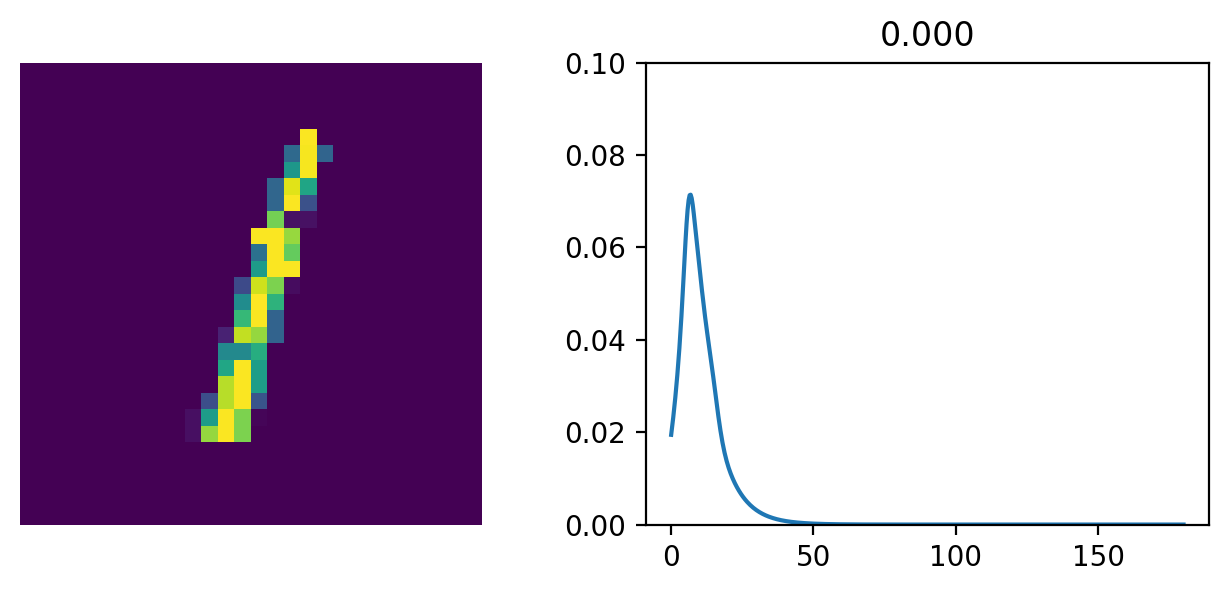

In [743]:
%%time
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

def animate(ix):
    plt.cla()
    rotation = rotations[ix]
    img = np.array(X_target)[ix].reshape(28, 28)
    density = distrax.Normal(loc=yhat_samples[:, ix], scale=std_samples[:, ix]).prob(rotations[:, None]).mean(axis=1)
    density = np.array(density)
    
    axs[0].imshow(img)
    axs[0].axis("off")
    axs[1].plot(rotations, density)
    axs[1].set_title(f"{rotation:0.3f}")
    axs[1].set_ylim(0, 0.1)

frames = np.arange(len(rotations))
anim = FuncAnimation(fig, animate, frames=frames)
anim.save("animation-rotating-one-ensemble.mp4", dpi=100, bitrate=-1, fps=10)